## Model Explainability with SHAP

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, SimpleRNN, LSTM
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import mlflow
import mlflow.sklearn
import mlflow.xgboost


In [3]:
import shap
import tqdm
import lime
import lime.lime_tabular
import os

e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load datasets
creditcard_df = pd.read_csv('E:/Git_repo/real-time-fraud-detection/data/creditcard_preprocessed.csv')
fraud_df = pd.read_csv('E:/Git_repo/real-time-fraud-detection/data/Processed_Fraud_Data.csv')

In [5]:
#### Check for missing values
print("Missing values in creditcard_preprocessed.csv:")
print(creditcard_df.isnull().sum())

print("\nMissing values in Processed_Fraud_Data.csv:")
print(fraud_df.isnull().sum())

#####creditcard_df.drop(columns=['ip_address'], inplace=True)
fraud_df.drop(columns=['ip_address'], inplace=True)

Missing values in creditcard_preprocessed.csv:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Missing values in Processed_Fraud_Data.csv:
user_id                    0
signup_time                0
purchase_time              0
purchase_value             0
device_id                  0
source                     0
browser                    0
sex                        0
age                        0
ip_address            151112
class                      0
signup_hour                0
signup_day                 0
purchase_hour              0
purchase_day               0
country                    0
log_purchase_value         0
region                     0
d

In [6]:
# Feature and target separation
def prepare_data(df, target_col):
    # Handle datetime columns (e.g., signup_time, purchase_time)
    date_columns = ['signup_time', 'purchase_time']  # Replace with the actual datetime columns
    for col in date_columns:
        if col in df.columns:
            # Convert to datetime format
            df[col] = pd.to_datetime(df[col], errors='coerce')
            # Extract useful time-related features (year, month, day, hour, etc.)
            df[f'{col}_year'] = df[col].dt.year
            df[f'{col}_month'] = df[col].dt.month
            df[f'{col}_day'] = df[col].dt.day
            df[f'{col}_hour'] = df[col].dt.hour
            df[f'{col}_minute'] = df[col].dt.minute
            df[f'{col}_second'] = df[col].dt.second
            # Drop the original datetime column
            df.drop(columns=[col], inplace=True)

    # Handle categorical columns (e.g., sex, browser, country, source, device_id)
    categorical_columns = ['sex', 'browser', 'country', 'source', 'device_id', 'region']  # Add more if needed
    label_encoder = LabelEncoder()
    for col in categorical_columns:
        if col in df.columns:
            df[col] = label_encoder.fit_transform(df[col].astype(str))

    # Separate features (X) and target (y)
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

In [7]:
fraud_df.shape, creditcard_df.shape

((151112, 17), (284807, 31))

In [8]:
fraud_df.columns, creditcard_df.columns

(Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
        'device_id', 'source', 'browser', 'sex', 'age', 'class', 'signup_hour',
        'signup_day', 'purchase_hour', 'purchase_day', 'country',
        'log_purchase_value', 'region'],
       dtype='object'),
 Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
        'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
        'Class'],
       dtype='object'))

# Model Building

In [9]:
# Model Building

X_credit, y_credit = prepare_data(creditcard_df, 'Class')
X_fraud, y_fraud = prepare_data(fraud_df, 'class')
print(np.unique(y_credit, return_counts=True))
print(np.unique(y_fraud, return_counts=True))

(array([0, 1]), array([284315,    492]))
(array([0, 1]), array([136961,  14151]))


In [21]:
# Model Building

X_fraud = fraud_df.drop(columns=['class'])
X_credit = creditcard_df.drop(columns=['Class'])
y_fraud = fraud_df['class']
y_credit = creditcard_df['Class']

#print(np.unique(y1, return_counts=True))
#print(np.unique(y2, return_counts=True))

In [22]:
# Train-test split
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit, y_credit, test_size=0.2, random_state=42)
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42)

### MLP

In [23]:
# Instantiate the MultiLayer Perceptron Model

mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42)

# Train the model
mlp_model.fit(X_train_fraud, y_train_fraud)

# Predictions
y_pred_mlp = mlp_model.predict(X_train_fraud)

# Evaluation
print(classification_report(y_train_fraud, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    109588
           1       1.00      0.00      0.00     11301

    accuracy                           0.91    120889
   macro avg       0.95      0.50      0.48    120889
weighted avg       0.92      0.91      0.86    120889



In [25]:
print("fraud_df shape:", fraud_df.shape)  # Should be (284,807, X)
print("X_fraud shape before dropping:", fraud_df.drop(columns=['class']).shape)
print("y_fraud shape:", fraud_df["class"].shape)


fraud_df shape: (151112, 27)
X_fraud shape before dropping: (151112, 26)
y_fraud shape: (151112,)


In [26]:
# Ensure X_fraud and y_fraud are derived from the same dataset
if "class" in fraud_df.columns:
    # Drop rows with missing values in features
    X_fraud = fraud_df.drop(columns=["class"]).copy()
    y_fraud = fraud_df["class"].copy()

    # Check again
    print("Fixed X_fraud shape:", X_fraud.shape)
    print("Fixed y_fraud shape:", y_fraud.shape)
else:
    raise ValueError("The dataset does not contain a 'Class' column.")



Fixed X_fraud shape: (151112, 26)
Fixed y_fraud shape: (151112,)


In [27]:
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

### LSTM

In [28]:
X_train_lstm = X_train_fraud.values.reshape(-1, X_train_fraud.shape[1], 1)
X_test_lstm = X_test_fraud.values.reshape(-1, X_test_fraud.shape[1], 1)

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_fraud.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_fraud, epochs=5, batch_size=32, validation_split=0.2) #validation_data=(X_test_fraud, y_test_fraud))


# Predictions
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")
print(classification_report(y_test_fraud, y_pred_lstm))

Epoch 1/5


e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3023/3023 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9359 - loss: 0.2310 - val_accuracy: 0.9524 - val_loss: 0.1878
Epoch 2/5
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9556 - loss: 0.1815 - val_accuracy: 0.9549 - val_loss: 0.1845
Epoch 3/5
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9551 - loss: 0.1819 - val_accuracy: 0.9561 - val_loss: 0.1798
Epoch 4/5
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9554 - loss: 0.1813 - val_accuracy: 0.9560 - val_loss: 0.1798
Epoch 5/5
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9563 - loss: 0.1781 - val_accuracy: 0.9564 - val_loss: 0.1781
945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.98      0.53      0.69      2830

    accuracy                           0.95     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.95      0.95    

### RNN

In [29]:
X_train_rnn = X_train_fraud.values.reshape(-1, X_train_fraud.shape[1], 1)
X_test_rnn = X_test_fraud.values.reshape(-1, X_test_fraud.shape[1], 1)

rnn_model = Sequential([
    SimpleRNN(64, input_shape=(X_train_fraud.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.fit(X_train_fraud, y_train_fraud, epochs=5, batch_size=32, validation_split=0.2) #validation_data=(X_test_fraud, y_test_fraud))


# Predictions
y_pred_rnn = (rnn_model.predict(X_test_rnn) > 0.5).astype("int32")
print(classification_report(y_test_fraud, y_pred_rnn))

Epoch 1/5


e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3023/3023 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9354 - loss: 0.2321 - val_accuracy: 0.9536 - val_loss: 0.1872
Epoch 2/5
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9516 - loss: 0.1931 - val_accuracy: 0.9535 - val_loss: 0.1907
Epoch 3/5
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9543 - loss: 0.1854 - val_accuracy: 0.9536 - val_loss: 0.1879
Epoch 4/5
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9526 - loss: 0.1903 - val_accuracy: 0.9529 - val_loss: 0.1895
Epoch 5/5
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9529 - loss: 0.1892 - val_accuracy: 0.9539 - val_loss: 0.1874
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27393
           1       0.94      0.52      0.67      2830

    accuracy                           0.95     30223
   macro avg       0.95      0.76      0.82     30223
weighted avg       0.95      0.95      0.95    

### CNN

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense 

X_train_cnn = X_train_fraud.values.reshape(-1, X_train_fraud.shape[1], 1)
X_test_cnn = X_test_fraud.values.reshape(-1, X_test_fraud.shape[1], 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_fraud.shape[1], 1)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_fraud, y_train_fraud, epochs=5, batch_size=32, validation_split=0.2) #validation_data=(X_test_fraud, y_test_fraud))


# Predictions
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")
print(classification_report(y_test_fraud, y_pred_cnn))

Epoch 1/5


e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3023/3023 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8301 - loss: 76.8194 - val_accuracy: 0.6041 - val_loss: 20.0245
Epoch 2/5
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8424 - loss: 12.3986 - val_accuracy: 0.9093 - val_loss: 3.2417
Epoch 3/5
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8673 - loss: 3.2618 - val_accuracy: 0.9183 - val_loss: 1.0995
Epoch 4/5
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8990 - loss: 0.6858 - val_accuracy: 0.9173 - val_loss: 0.3923
Epoch 5/5
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9183 - loss: 0.2812 - val_accuracy: 0.9198 - val_loss: 0.2284
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27393
           1       0.80      0.18      0.29      2830

    accuracy                           0.92     30223
   macro avg       0.86      0.59      0.62     30223
weighted avg       0.91      0.92      0.89   

### Logistic Regression

In [33]:
logreg_fraud = LogisticRegression(C=1, solver='liblinear')
logreg_fraud.fit(X_train_fraud, y_train_fraud)
y_pred_logreg = logreg_fraud.predict(X_test_fraud)

print(classification_report(y_test_fraud, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     27393
           1       0.98      0.06      0.11      2830

    accuracy                           0.91     30223
   macro avg       0.95      0.53      0.53     30223
weighted avg       0.92      0.91      0.87     30223



In [34]:
logreg_credit = LogisticRegression(C=1, solver='liblinear')
logreg_credit.fit(X_train_credit, y_train_credit)
y_pred_logreg2 = logreg_credit.predict(X_test_credit)
print(classification_report(y_test_credit, y_pred_logreg2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.48      0.61        98

    accuracy                           1.00     56962
   macro avg       0.92      0.74      0.80     56962
weighted avg       1.00      1.00      1.00     56962



### Random Forests

In [37]:
rf_fraud = RandomForestClassifier(n_estimators=100, max_depth=10)
rf_fraud.fit(X_train_fraud, y_train_fraud)
y_pred_rf1 = rf_fraud.predict(X_test_fraud)
print(classification_report(y_test_fraud, y_pred_rf1))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.96      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.96      0.76      0.83     30223
weighted avg       0.95      0.95      0.95     30223



In [38]:
rf_credit = RandomForestClassifier(n_estimators=100, max_depth=10)
rf_credit.fit(X_train_credit, y_train_credit)
y_pred_rf2 = rf_credit.predict(X_test_credit)
print(classification_report(y_test_credit, y_pred_rf2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962



### Gradient Boosting

In [41]:
xgb_fraud = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb_fraud.fit(X_train_fraud, y_train_fraud)
y_pred_xgb1 = xgb_fraud.predict(X_test_fraud)
print(classification_report(y_test_fraud, y_pred_xgb1))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27393
           1       0.95      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.95      0.76      0.83     30223
weighted avg       0.95      0.95      0.95     30223



In [42]:
xgb_credit = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb_credit.fit(X_train_credit, y_train_credit)
y_pred_xgb2 = xgb_credit.predict(X_test_credit)
print(classification_report(y_test_credit, y_pred_xgb2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.60      0.66        98

    accuracy                           1.00     56962
   macro avg       0.87      0.80      0.83     56962
weighted avg       1.00      1.00      1.00     56962



### Save the models

In [ ]:
# Save the model
import pickle
with open('E:/Git_repo/real-time-fraud-detection/models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_fraud, f)

with open('E:/Git_repo/real-time-fraud-detection/models/gradient_model.pkl', 'wb') as f:
    pickle.dump(xgb_fraud, f)

with open('E:/Git_repo/real-time-fraud-detection/models/logreg_model.pkl', 'wb') as f:
    pickle.dump(logreg_fraud, f)

with open('E:/Git_repo/real-time-fraud-detection/models/lstm_model.pkl', 'wb') as f:
    pickle.dump(lstm_model, f)

with open('E:/Git_repo/real-time-fraud-detection/models/rnn_model.pkl', 'wb') as f:
    pickle.dump(rnn_model, f)

with open('E:/Git_repo/real-time-fraud-detection/models/cnn_model.pkl', 'wb') as f:
    pickle.dump(cnn_model, f)

# Explainability with SHAP

In [ ]:
# SHAP explanation for fraud dataset using KernelExplainer
explainer_lstm = shap.Explainer(lstm_model, X_train_fraud)  
shap_valuesfr = explainer_lstm(X_test_fraud)  

# Plot summary plot for fraud data
shap.summary_plot(shap_valuesfr, X_test_fraud, feature_names=X_fraud.columns)

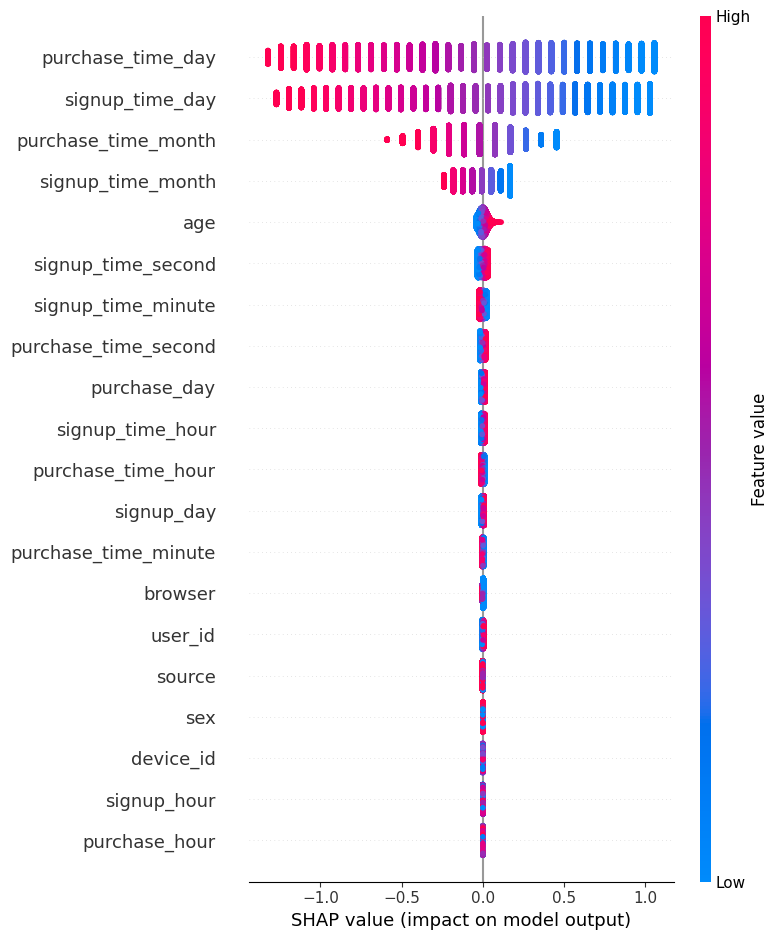

In [ ]:
# SHAP explanation for fraud dataset using KernelExplainer
explainer_logreg = shap.Explainer(logreg_fraud, X_train_fraud)  
shap_values1 = explainer_logreg(X_test_fraud)  

# Plot summary plot for fraud data
shap.summary_plot(shap_values1, X_test_fraud, feature_names=X_fraud.columns)

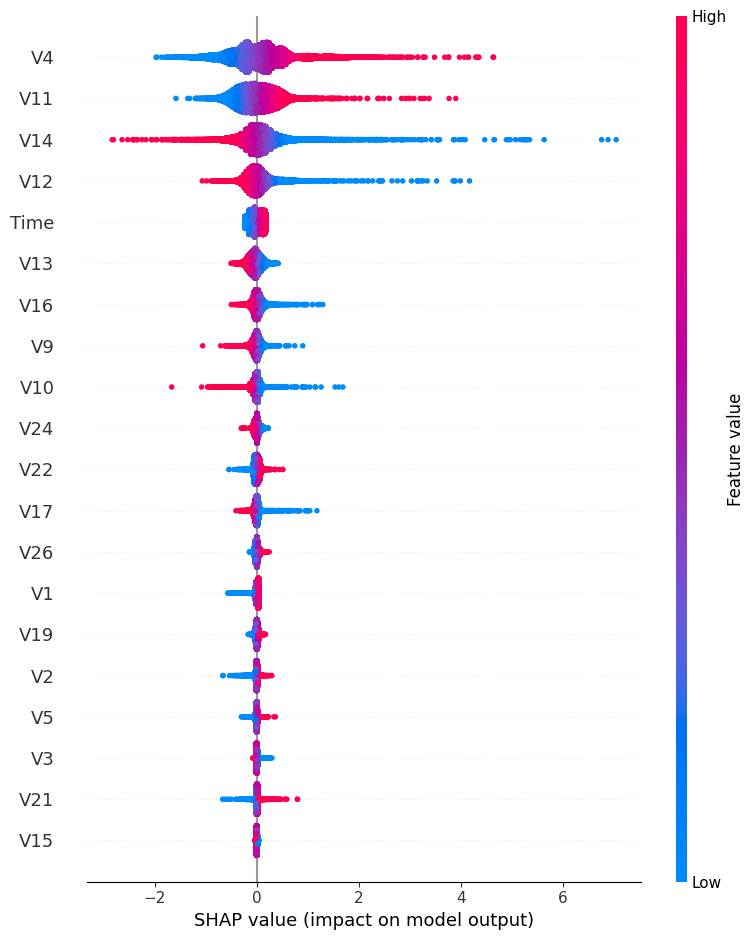

In [ ]:
# SHAP explanation for creditcard dataset using KernelExplainer
explainer_logreg2 = shap.Explainer(logreg_credit, X_train_credit) 
shap_valueslog = explainer_logreg2(X_test_credit)  

# Plot summary plot for creditcard data
shap.summary_plot(shap_valueslog, X_test_credit, feature_names=X_credit.columns)

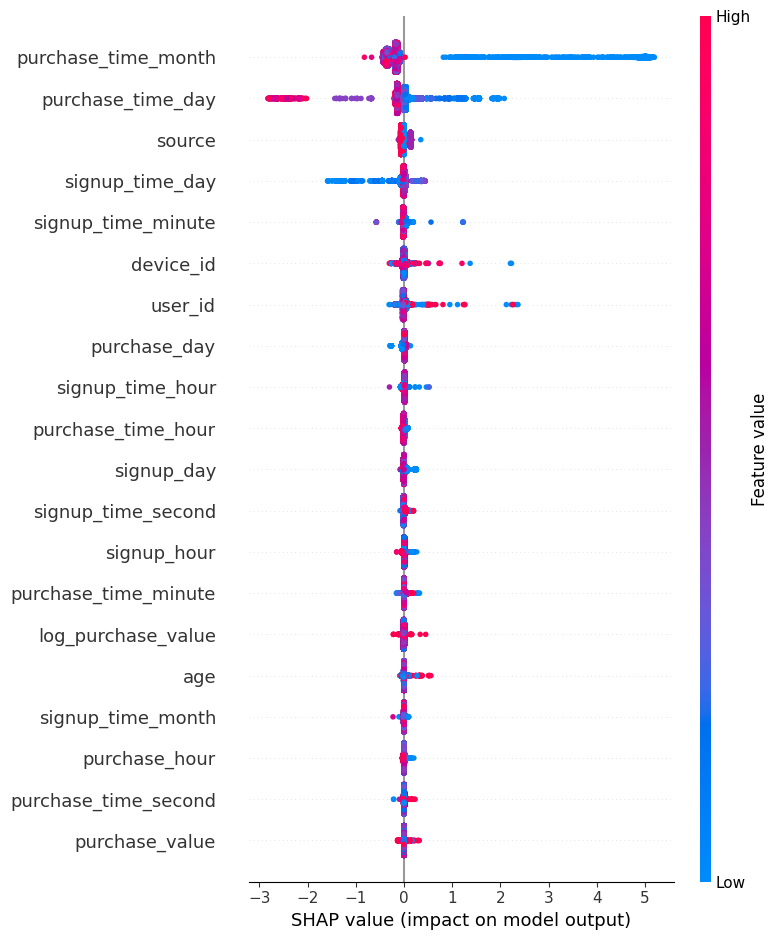

In [46]:
# SHAP explanation for XGBoost model
explainer_xgb = shap.Explainer(xgb_fraud)  
shap_values_xgb = explainer_xgb(X_test_fraud)

# Plot summary plot for XGBoost model
shap.summary_plot(shap_values_xgb, X_test_fraud, feature_names=X_fraud.columns)

# Local interpretability with LIME

In [ ]:
# Create LIME explainer for GradientBoosting classifier
explainer_xgbfr = lime.lime_tabular.LimeTabularExplainer(X_train_fraud.values, 
                                                       feature_names=X_train_fraud.columns, 
                                                       class_names=['Class 0', 'Class 1'], 
                                                       discretize_continuous=True)

# Pick an instance to explain (e.g., first test instance)
i = 0
exp_xgbfr = explainer_xgbfr.explain_instance(X_test_fraud.iloc[i], xgb_fraud.predict_proba)

# Display explanation for the XGBoost model
exp_xgbfr.show_in_notebook()

In [ ]:
# Create LIME explainer for GradientBoosting classifier
explainer_xgbcrc = lime.lime_tabular.LimeTabularExplainer(X_train_credit.values, 
                                                       feature_names=X_train_credit.columns, 
                                                       class_names=['Class 0', 'Class 1'], 
                                                       discretize_continuous=True)

# Pick an instance to explain (e.g., first test instance)
i = 0
exp_xgbcrc = explainer_xgbcrc.explain_instance(X_test_credit.iloc[i], xgb_credit.predict_proba)

# Display explanation for the XGBoost model
exp_xgbcrc.show_in_notebook()

In [ ]:
from lime import lime_tabular

# Initialize the LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(X_train_fraud.values, feature_names=X_train_fraud.columns, class_names=['Not Fraud', 'Fraud'], mode='classification')

# Explain a single instance from the test set
exp = lime_explainer.explain_instance(X_test_fraud.values[0], mlp_model.predict_proba)
exp.show_in_notebook()